## Introduction
There has been a lot of hype about generating images from text. However, I had not seen many things in the caption generation domain. This is obviously the easier of the two problems, and perhaps it has been mostly solved, but I thought I'd get my hands dirty trying to do this almost from scratch. Before we get going HF does have [`VisionEncoderDecoderModel`s](https://huggingface.co/docs/transformers/model_doc/visionencoderdecoder) which does exactly what we are doing today, but I wanted to try and build this from mostly scratch.

Visual Transformers was used to classify images in the Imagenet problem and GPT2 is a language model than can be used to generate text. So the question is can we combine these two? And the answer is yes, thanks to [`EncoderDecoderModel`s](https://huggingface.co/docs/transformers/model_doc/encoderdecoder) from HF. In the original [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) paper, using attention was the game changer. Not many people are aware however, that there were two kinds of attention. 1. Self-attention which most people are familiar with, 2. Cross-attention which allows the decoder to retrieve information from the encoder.
![Cross Attention](https://i.imgur.com/CSeBK1m.png)

By default GPT-2 does not have this cross attention layer pre-trained. [This paper](https://arxiv.org/pdf/1907.12461.pdf) by Google Research demonstrated that you can simply randomly initialise these cross attention layers and train the system. And this is exactly what we will be doing in this blog using the COCO dataset. An executable version of this can be found [here on kaggle](https://www.kaggle.com/sachin/vit-to-gpt2-encoder-decoder-model).

In [4]:
#| include: false
%%capture
!pip install pycocotools
!pip install --upgrade wandb

import multiprocessing as mp
import random
from typing import Callable, Dict, List, Optional, Tuple, Union

# from deepspeed.ops.adam import FusedAdam
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import io, transforms
import torchvision.datasets as dset
from tqdm.auto import tqdm
from transformers import EncoderDecoderModel, GPT2Tokenizer, ViTFeatureExtractor

# Wandb login:
from kaggle_secrets import UserSecretsClient
import wandb
user_secrets = UserSecretsClient()
secret_value = user_secrets.get_secret("wandb_api_key")
wandb.login(key=secret_value)

In [2]:
#| include: false
## CONFIG
VIT_MODEL = "google/vit-base-patch16-224-in21k"
GPT2 = "gpt2"
DISTIL_GPT2 = "distilgpt2"

DATA_PATH = "/kaggle/input/coco-2017-dataset/coco2017/"
ANNOTATION_PATH = DATA_PATH + "annotations/captions_train2017.json"

MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

TRAIN_PCT = 0.95
NUM_WORKERS = 2
BATCH_SIZE = 8
EPOCHS = 3
LR = 1e-4
IMAGE_SIZE = (224, 224)

MAX_TEXT_LENGTH = 32

LABEL_MASK = -100

TOP_K = 1000
TOP_P = 0.95

In [3]:
#| include: false
## Data
tfms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE), 
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5, 
            std=0.5
        )
   ]
)
descale = transforms.Compose(
    [
        transforms.Normalize(
            mean = [ 0., 0., 0. ],
            std = 1 / 0.5
        ),
        transforms.Normalize(
            mean = -0.5,
            std = [ 1., 1., 1. ]
        ),                           
    ]
)

target_tfm = lambda x: random.choice(x)

coco_dataset = dset.CocoCaptions(root = DATA_PATH + "train2017/",
                        annFile = ANNOTATION_PATH,
                        transform=tfms,
                        target_transform=target_tfm,
)

print('Number of samples: ', len(coco_dataset))
img, caption = coco_dataset[3] # load 4th sample

loading annotations into memory...
Done (t=2.61s)
creating index...
index created!
Number of samples:  118287


## Data
The coco dataset provides us with an image and 5 possible captions. We choose one at random during each epoch.

A lone zebra grazing in some green grass.


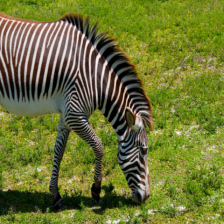

In [4]:
print(caption)
transforms.ToPILImage()(descale(img))

In [5]:
#| include: false
train_len = int(TRAIN_PCT * len(coco_dataset))
train_data, valid_data = random_split(coco_dataset, [train_len, len(coco_dataset) - train_len])
train_dl = DataLoader(
    train_data, 
    BATCH_SIZE, 
    pin_memory=True, 
    shuffle=True, 
    num_workers=NUM_WORKERS, 
    drop_last=True
)
valid_dl = DataLoader(
    valid_data, 
    BATCH_SIZE, 
    pin_memory=True, 
    shuffle=False, 
    num_workers=NUM_WORKERS, 
    drop_last=False
)

images, captions = next(iter(train_dl))
images.shape, images.min(), images.max(), images.mean(), images.std()

(torch.Size([8, 3, 224, 224]),
 tensor(-1.),
 tensor(1.),
 tensor(0.1255),
 tensor(0.5039))

## GPT2 Tokenizer and Model

As mentioned earlier, we will use the `EncoderDecoderModel` which will initialize the cross attention layers for us, and use pretrained weights from the Visual Transformer and (distil) GPT2. We only use the distil version for the sake of quick training, and as you will see soon, is good enough.

The tokenizer requires a bit more preprocessing than what you'd be used to compared to a BERT tokenizer. The following tokenizer code is something I copied (sorry don't remember where), but the important bit is that a padding token was required to be introduced which I thought was strange. Mostly because how would GPT-2 have been trained without padding?

In [6]:
#| output: false
# model
vit2gpt2 = EncoderDecoderModel.from_encoder_decoder_pretrained(VIT_MODEL, DISTIL_GPT2)

# tokenizer
# make sure GPT2 appends EOS in begin and end
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs
    
GPT2Tokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(DISTIL_GPT2)
# set pad_token_id to unk_token_id -> be careful here as unk_token_id == eos_token_id == bos_token_id
gpt2_tokenizer.pad_token = gpt2_tokenizer.unk_token

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/353M [00:00<?, ?B/s]

## Nucleus Sampling
At the time of writing it seems that `EncoderDecoderModel` does not seem to have a `generate` method which is used by GPT-2 etc. to generate text. Hence the following code. 

Sampling the next token/ word is not simply a matter of taking the highest likelihood of the next token. This is due to the fact that there is no guarantee that the (log) likelihood of the entire sequence is maximised by taking the maximum at each token. This will lead to a sub-optimal answer. Beam search is an alternate method where you keep the top k tokens and iterate to the end, and hopefully one of the k beams will contain the solution we are after.

In the code below we use a sampling based method named [Nucleus Sampling](https://arxiv.org/pdf/1904.09751.pdf) which is shown to have superior results and minimises common pitfalls such as repetition when generating text. The algorithm is as follows:

- Choose all _largest_ tokens that sums up to a given threshold.
- Set all other token probabilities to zero, and renormalize probability distribution.
- Sample from above distribution.
- In the code below, apart from a threshold on top probable tokens, we also have a limit on possible tokens which is defaulted to a large number (1000).

In [5]:
def top_k_top_p_filtering(
    next_token_logits: torch.FloatTensor,
    top_k: Optional[float]=None, 
    top_p: Optional[float]=None,
    device: Union[str, torch.device]="cpu",
) -> torch.FloatTensor:
    if top_k is None:
        top_k = next_token_logits.shape[-1]
    if top_p is None:
        top_p = 1.0
        
    p, largest_p_idx = F.softmax(next_token_logits, dim=-1).topk(top_k, dim=-1)
    cumulative_p = p.cumsum(dim=-1)
    threshold_repeated = top_p + torch.zeros((len(p),1)).to(device)
    idx = torch.searchsorted(cumulative_p, threshold_repeated).clip(max=top_k-1).squeeze()
    cutoffs = cumulative_p[torch.arange(len(cumulative_p)), idx]
    censored_p = (cumulative_p <= cutoffs[:, None]) * p
    renormalized_p = censored_p / censored_p.sum(dim=-1, keepdims=True)
    
    final_p = torch.zeros_like(next_token_logits)
    row_idx = torch.arange(len(p)).unsqueeze(1).repeat(1,top_k).to(device)
    final_p[row_idx, largest_p_idx] = renormalized_p.to(final_p.dtype)

    return final_p

In order to generate the actual sequence we need 1. The image representation according to the encoder (ViT) and 2. The generated tokens so far. Note that the first token is _always_ going to be a beginning of sentence token (`<BOS>`). We pass the generated tokens iteratively for a predefined length or until end of sentence is reached. In the following since we are using a batch, we ignore the `<EOS>` token.

In [ ]:
def generate_sentence_from_image(model, encoder_outputs, tokenizer, max_text_length: int, device)-> List[str]:
    generated_so_far = torch.LongTensor([[tokenizer.bos_token_id]]*len(encoder_outputs.last_hidden_state)).to(device)
    with torch.no_grad():
        for _ in tqdm(range(max_text_length)):
            attention_mask = torch.ones_like(generated_so_far)
            decoder_out = model(
                decoder_input_ids=generated_so_far, 
                decoder_attention_mask=attention_mask,
                encoder_outputs=encoder_outputs
            )

            next_token_logits = decoder_out["logits"][:, -1, :]
            filtered_p = top_k_top_p_filtering(next_token_logits, top_k=TOP_K, top_p=TOP_P, device=device)
            next_token = torch.multinomial(filtered_p, num_samples=1)
            generated_so_far = torch.cat((generated_so_far, next_token), dim=1)

    return [tokenizer.decode(coded_sentence) for coded_sentence in generated_so_far]

## Training Module (PyTorch Lightning)
Expand the button below to see the pytorch lightning code. There are a few things to note in the training step.

1. Train only the cross-attention weights. This was a design decision based on time available, and not a necessity. This however meant that I was able to train an epoch of 110000 image caption pairs in 30 minutes.
```python
for name, param in self.model.named_parameters():
    if "crossattention" not in name:
        param.requires_grad = False
```
2. Loss was calculated for you by HF. However, if you wish to understand how exactly HF calculates loss, that can be found in [this discussion that I authored](https://discuss.huggingface.co/t/encoder-decoder-loss/4335/4?u=sachin).

```python
encoder_outputs = self.model.encoder(pixel_values=images)
outputs = self.model(
    encoder_outputs=encoder_outputs,
    decoder_input_ids=tokenized_captions["input_ids"],
    decoder_attention_mask=tokenized_captions["attention_mask"],
    labels=labels,
    return_dict=True,
)

return outputs["loss"]
```
3. Weights and Biases are amazing and you should log all your experiments. The `wandb.Table` element especially was a godsend.

In [8]:
#| code-fold: true
class LightningModule(pl.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        tokenizer,
        lr: float,
    ):
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.lr = lr
        
        for name, param in self.model.named_parameters():
            if "crossattention" not in name:
                param.requires_grad = False
        
    def common_step(self, batch: Tuple[torch.FloatTensor, List[str]]) -> torch.FloatTensor:
        images, captions = batch
        tokenized_captions = {
            k: v.to(self.device) for k, v in 
            self.tokenizer(
                captions,
                max_length=MAX_TEXT_LENGTH,
                truncation=True,
                padding=True,
                return_tensors="pt",
            ).items()
        }
        labels = tokenized_captions["input_ids"].clone()
        labels[tokenized_captions["attention_mask"]==0] = LABEL_MASK
        encoder_outputs = self.model.encoder(pixel_values=images)
        outputs = self.model(
            encoder_outputs=encoder_outputs,
            decoder_input_ids=tokenized_captions["input_ids"],
            decoder_attention_mask=tokenized_captions["attention_mask"],
            labels=labels,
            return_dict=True,
        )
        
        return outputs["loss"]
    
    def training_step(self, batch: Tuple[torch.FloatTensor, List[str]], batch_idx: int) -> torch.FloatTensor:
        loss = self.common_step(batch)
        self.log(name="Training loss", value=loss, on_step=True, on_epoch=True)
        
        return loss
        
    def validation_step(self, batch: Tuple[torch.FloatTensor, List[str]], batch_idx: int):
        loss = self.common_step(batch)
        self.log(name="Validation loss", value=loss, on_step=True, on_epoch=True)

        images, actual_sentences = batch
        
        if batch_idx == 0:
            encoder_outputs = self.model.encoder(pixel_values=images.to(self.device))
            generated_sentences = generate_sentence_from_image(
                self.model, 
                encoder_outputs, 
                self.tokenizer, 
                MAX_TEXT_LENGTH,
                self.device
            )
            images = [wandb.Image(transforms.ToPILImage()(descale(image))) for image in images]
            data = list(map(list, zip(images, actual_sentences, generated_sentences)))
            columns = ["Images", "Actual Sentence", "Generated Sentence"]
            table = wandb.Table(data=data, columns=columns)
            self.logger.experiment.log({f"epoch {self.current_epoch} results": table})
                        
    def on_after_backward(self):
        if self.trainer.global_step % 50 == 0:  # don't make the tf file huge
            for name, param in self.model.named_parameters():
                if "weight" in name and not "norm" in name and param.requires_grad:
                    self.logger.experiment.log(
                        {f"{name}_grad": wandb.Histogram(param.grad.detach().cpu())}
                    )
                    self.logger.experiment.log(
                        {f"{name}": wandb.Histogram(param.detach().cpu())}
                    )

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)
            

In [9]:
#| include: false
!mkdir -p /kaggle/working/logs
lightning_module = LightningModule(
    vit2gpt2,
    gpt2_tokenizer,
    LR
)

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    gpus=torch.cuda.device_count(),
    gradient_clip_val=1.0,
    logger=WandbLogger("Frozen", "/kaggle/working/logs/", project="Vit2GPT2"),
    precision=16,
    num_sanity_val_steps=0,
)
trainer.fit(lightning_module, train_dl, valid_dl)

wandb: Currently logged in as: sachinruk (use `wandb login --relogin` to force relogin)


Training: -1it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/plugins/precision/precision_plugin.py:138: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  torch.nn.utils.clip_grad_norm_(parameters, clip_val)


Validating: 0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

## Results
The full set of results can be seen [here](https://wandb.ai/sachinruk/Vit2GPT2/runs/3a9ac2yu?workspace=user-sachinruk) but here's some highlights:
![teddy](https://i.imgur.com/qsaJOly.png)
Actual caption: A teddy bear and a metronome sitting on a table top. Generated caption: <|endoftext|>A stuffed teddy bear is being laid down next to a table.<|endoftext|>
![cat](https://i.imgur.com/8VEGoNS.png)
Actual caption: A white cat is sitting on a laptop. Generated caption: <|endoftext|>A cat sitting on a stool with an empty laptop.<|endoftext|>
![cow](https://i.imgur.com/sxg5CM3.png)
Actual caption: The cows are laying down in a straight row. Generated caption: <|endoftext|>A horse is drinking milk and taking pictures of cattle inside.<|endoftext|>

Atleast the last one captured cattle, not sure about the shifty horse 🤔.

## Gotchas and Potential Improvements
The biggest problem I had training this model was gradient explosion. When I chose the learning rate too high (1e-3) the weights quickly hit infinity, too small 1e-5 and the generated text wasn't so good. So it was possibly worth unfreezing the weights after one epoch and training with a smaller learning rate. The following is a cross section of the histograms of one set of weights. As you can see it goes into the 1000s even though I managed to train it succesfully which is concerning:
![](https://i.imgur.com/aFIAn6z.png)

Perhaps putting some sort of normalization would have fixed the gradient explosion, but that is something unfortunately I don't have access to as this is done for me by HF `EncoderDecoderModel` API.

## Shameless Self Promotion
If you enjoyed the tutorial [buy my course](https://www.udemy.com/course/machine-learning-and-data-science-2021/?referralCode=E79228C7436D74315787) (usually 90% off).